In [1]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


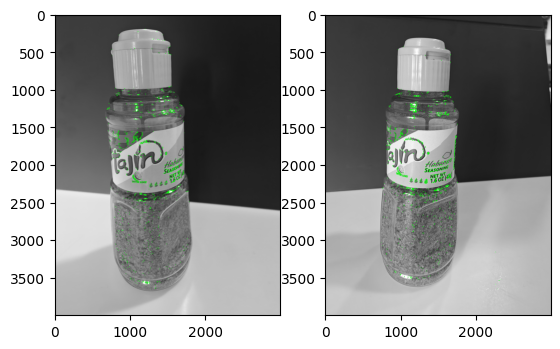

In [2]:
#1. NeRF Feature Detection

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the path to the images folder on Google Drive
base_path = "/content/drive/MyDrive/DSC 210 Final Project/NeRF_implementation/"
images_path = base_path + "images_folder/"

# Load the images (update with the correct paths from Google Drive)
image1 = cv2.imread(images_path + 'Image3.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(images_path + 'Image6.jpg', cv2.IMREAD_GRAYSCALE)

# Check if the images were loaded successfully
if image1 is None:
  print("Error loading image1.jpg")
if image2 is None:
  print("Error loading image2.jpg")

# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=10000, scaleFactor=1.1, nlevels=8)

# Detect keypoints and descriptors
kp1, des1 = orb.detectAndCompute(image1, None)
kp2, des2 = orb.detectAndCompute(image2, None)

# Draw keypoints
img1_kp = cv2.drawKeypoints(image1, kp1, None, color=(0, 255, 0), flags=0)
img2_kp = cv2.drawKeypoints(image2, kp2, None, color=(0, 255, 0), flags=0)

# Plot the keypoints
plt.subplot(1, 2, 1), plt.imshow(img1_kp)
plt.subplot(1, 2, 2), plt.imshow(img2_kp)
plt.show()


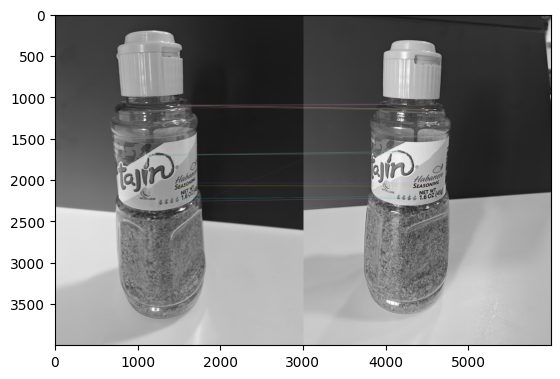

In [3]:
#2 NeRF Feature matching

#Initialize the Brute Force Matcher (BFMatcher)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors between the two images
matches = bf.match(des1, des2)

# Sort the matches based on distance (the smaller the distance, the better the match)
matches = sorted(matches, key = lambda x: x.distance)

# Draw the matches
img_matches = cv2.drawMatches(image1, kp1, image2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the image with the matched keypoints
plt.imshow(img_matches)
plt.show()


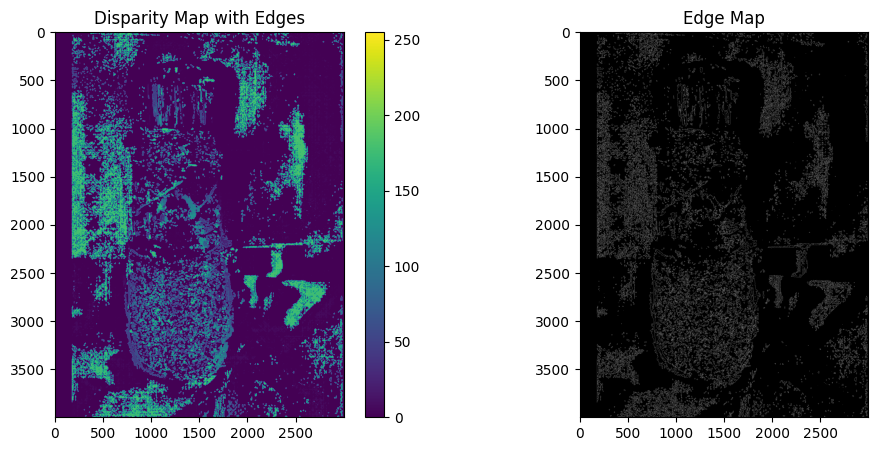

In [4]:
#3 NeRF Disparity and Edge Map

# Function to preprocess images
def preprocess_images(img1, img2):
    if len(img1.shape) == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img1 = clahe.apply(img1)
    img2 = clahe.apply(img2)

    # Bilateral filtering for denoising
    img1 = cv2.bilateralFilter(img1, 9, 75, 75)
    img2 = cv2.bilateralFilter(img2, 9, 75, 75)

    return img1, img2

# Function to create stereo matcher
def create_stereo_matcher():
    window_size = 7
    min_disp = -16
    num_disp = 192
    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=2,
        uniquenessRatio=10,
        speckleWindowSize=50,
        speckleRange=4,
        preFilterCap=31,
        mode=cv2.STEREO_SGBM_MODE_HH
    )
    return stereo

# Function to post-process disparity map
def post_process_disparity(disparity):
    # Convert to float32
    disparity = disparity.astype(np.float32) / 16.0

    # Apply bilateral filter for smoothing
    disparity = cv2.bilateralFilter(disparity, 9, 75, 75)

    # Detect edges
    edges = cv2.Canny(np.uint8(disparity), 50, 150)

    # Combine disparity with edges
    disparity_with_edges = disparity.copy()
    disparity_with_edges[edges > 0] = 255

    return disparity_with_edges

# Load images
#image1 = cv2.imread(image1_path)
#image2 = cv2.imread(image2_path)

# Check if images are loaded
if image1 is None or image2 is None:
    print("Error: One or both images could not be loaded.")
else:
    # Preprocess images
    processed_left, processed_right = preprocess_images(image1, image2)

    # Compute disparity
    stereo = create_stereo_matcher()
    disparity = stereo.compute(processed_left, processed_right)

    # Post-process disparity
    filtered_disparity = post_process_disparity(disparity)

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.imshow(cv2.normalize(filtered_disparity, None, 0, 255, cv2.NORM_MINMAX), cmap='viridis')
    plt.title('Disparity Map with Edges')
    plt.colorbar()

    plt.subplot(122)
    plt.imshow(cv2.Canny(np.uint8(filtered_disparity), 50, 150), cmap='gray')
    plt.title('Edge Map')
    plt.show()


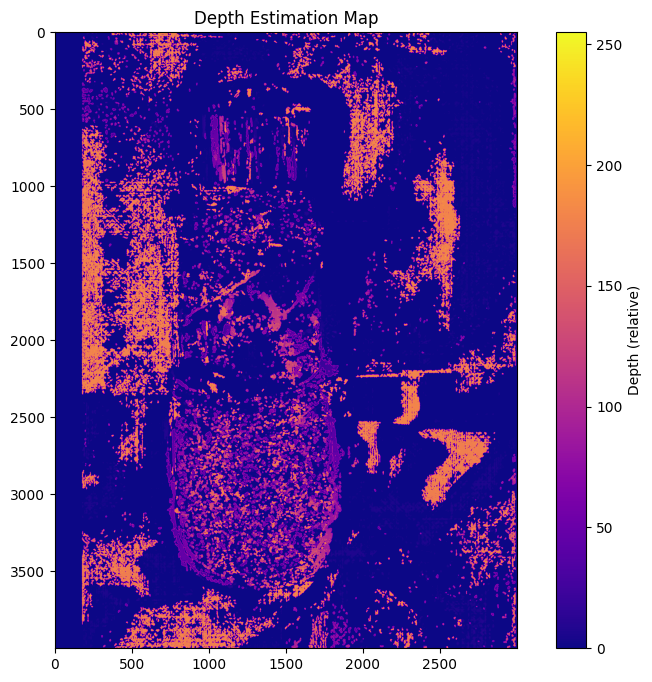

In [5]:
#4 NeRF Depth Estimation

# Set paths to the images
image1_path = images_path + 'Image3.jpg'
image2_path = images_path + 'Image6.jpg'

# Check if files exist
if not os.path.exists(image1_path):
    print(f"Error: {image1_path} does not exist.")
if not os.path.exists(image2_path):
    print(f"Error: {image2_path} does not exist.")

def preprocess_images(img1, img2):
    if len(img1.shape) == 3:  # Convert to grayscale if not already
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    img1 = clahe.apply(img1)
    img2 = clahe.apply(img2)

    # Apply bilateral filtering for noise reduction
    img1 = cv2.bilateralFilter(img1, 11, 75, 75)
    img2 = cv2.bilateralFilter(img2, 11, 75, 75)

    return img1, img2

def create_stereo_matcher():
    window_size = 9
    min_disp = -32
    num_disp = 256

    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=5,
        speckleWindowSize=200,
        speckleRange=2,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_HH
    )
    return stereo

# Compute disparity map
disparity = stereo.compute(processed_left, processed_right)

# Check if disparity map is valid
if disparity is None:
    print("Error: Failed to compute disparity map.")
else:
    # Post-process disparity map
    filtered_disparity = post_process_disparity(disparity)

    # Normalize disparity for visualization
    depth_map = cv2.normalize(filtered_disparity, None, 0, 255, cv2.NORM_MINMAX)
    depth_map = np.uint8(depth_map)  # Ensure valid image type for plotting

    # Visualize the depth estimation
    plt.figure(figsize=(10, 8))
    plt.imshow(depth_map, cmap='plasma')  # Use the "plasma" colormap for depth
    plt.colorbar(label='Depth (relative)')
    plt.title('Depth Estimation Map')
    plt.show()
